## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download data

In [2]:
aoi_dir = f'../../data/external/temporal_todocker/arroyo_vivo/cuenca_arroyo_32614.gpkg'
pois_dir = f'../../data/external/temporal_todocker/arroyo_vivo/residuos_arroyovivo_v3_encuenca_32614.gpkg'
resolutions = [10,11]

<Axes: >

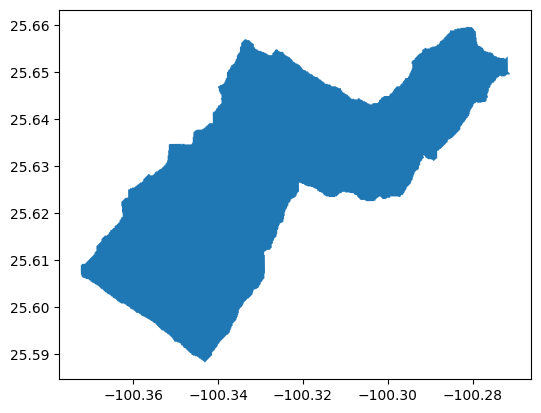

In [3]:
aoi = gpd.read_file(aoi_dir)
aoi = aoi.to_crs("EPSG:4326")

# Show
aoi.plot()

In [6]:
pois = gpd.read_file(pois_dir)
pois = pois.to_crs("EPSG:4326")

# Show
print(pois.shape)
pois.head(1)

(16179, 9)


,itemname,tipo,material,quantity,latitude,longitude,altitude,data_origin,geometry
0,Latas de aluminio o estaño,NaN,Aluminio,11,25.644154,-100.310618,627.104902,9 de enero.csv,MULTIPOINT (-100.31062 25.64415)


## Create hexgrid and group by hex data

In [4]:
# Create buffer for aoi in order to create a hexgrid that includes all the area
aoi_buffer = aoi.to_crs("EPSG:6372").buffer(60)
aoi_buffer = aoi_buffer.to_crs("EPSG:4326")
aoi_buffer = gpd.GeoDataFrame(geometry=aoi_buffer).dissolve()

# Go back to EPSG:4326
aoi = aoi.to_crs("EPSG:4326")

In [7]:
materiales_list = list(pois.material.unique())

pois_copy = pois.copy()
pois_copy.loc[:,'count'] = 1

i = 0

for res in resolutions:
    # Create hexgrid
    hexgrid = aup.create_hexgrid(aoi_buffer,res)
    
    # Duplicate hexgrid to merge later
    summary_tmp = hexgrid.copy()

    for material in materiales_list:
        pois_process = pois_copy.loc[pois.material == material]
        pois_inhex = gpd.sjoin(pois_process, hexgrid)

        # Sum by hex count (individual points) and quantity (how much trash was registered in that point)
        groupby = pois_inhex.groupby(f'hex_id_{res}').agg({'count':np.sum,
                                                           'quantity':np.sum})
        groupby.rename(columns={'count':material,
                                'quantity':f'{material}_quantity'},inplace=True)
        groupby = groupby[[material,f'{material}_quantity']]

        # Join groupby with geometry
        summary_tmp = pd.merge(summary_tmp,groupby, on=f'hex_id_{res}',how='outer')
        
    # Add resolution currently processed and change hex_id column name
    summary_tmp['res'] = res
    summary_tmp.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        
    if i == 0:
        summary = summary_tmp.copy()
    else:
        summary = pd.concat([summary,summary_tmp])
        
    i = i+1

# Additional data -----------------------------------------------
# Delete NaNs
summary = summary.fillna(0)

# Sum total garbage points by hex and find most common residue by total data
summary['total_points'] = summary[materiales_list].sum(axis=1)
summary['most_common_point'] = summary[materiales_list].idxmax(axis=1)

# Sum total garbage quantity by hex and find most common residue by total quantity data
materiales_quantity_list = []
for material in materiales_list:
    column_name = f'{material}_quantity'
    materiales_quantity_list.append(column_name)
    
summary['total_quantity'] = summary[materiales_quantity_list].sum(axis=1)
summary['most_common_quantity'] = summary[materiales_quantity_list].idxmax(axis=1)

# Delete hexs without data
idx = summary['total_points'] != 0
summary_f = summary.loc[idx]
#Sort values 
summary_f = summary_f.sort_values(by='total_points',ascending=False)

# Show -----------------------------------------------
print(summary_f.shape)
summary_f.head(1)

(562, 51)


,hex_id,geometry,Aluminio,Aluminio_quantity,Baterias,Baterias_quantity,Carton,Carton_quantity,Cenizas,Cenizas_quantity,...,Unicel_quantity,Vidrio,Vidrio_quantity,EPI,EPI_quantity,res,total_points,most_common_point,total_quantity,most_common_quantity
1111,8a48a20296a7fff,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,0.0,...,259.0,89.0,137.0,1.0,1.0,10,1918.0,Plastico,2669.0,Plastico_quantity


## Paso a paso - Inicio

### Create hexgrid

(13226, 2)


<Axes: >

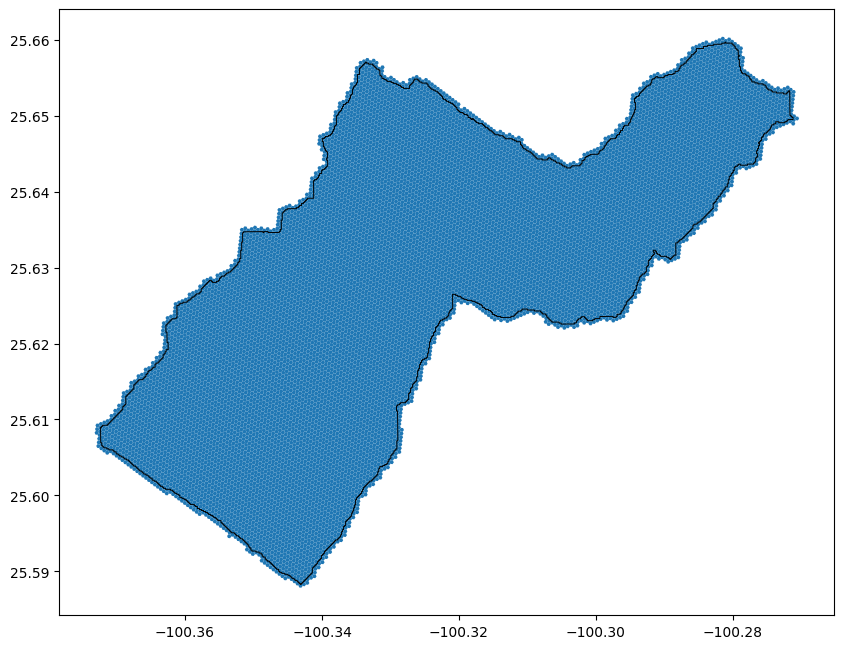

In [14]:
# Create buffer for aoi in order to create a hexgrid that includes all the area
aoi_buffer = aoi.to_crs("EPSG:6372").buffer(60)
aoi_buffer = aoi_buffer.to_crs("EPSG:4326")
aoi_buffer = gpd.GeoDataFrame(geometry=aoi_buffer).dissolve()

# Go back to EPSG:4326
aoi = aoi.to_crs("EPSG:4326")

# Create hexgrid
hexgrid = aup.create_hexgrid(aoi_buffer,resolution)

# Show
print(hexgrid.shape)

fig,ax = plt.subplots(figsize=(10,10))
hexgrid.plot(ax=ax,zorder=1)
aoi.plot(ax=ax, zorder=2, facecolor="none", edgecolor='black', lw=0.7)

### Group data by hex

In [11]:
materiales_list = list(pois.material.unique())

In [27]:
summary = hexgrid.copy()

pois_copy = pois.copy()
pois_copy.loc[:,'count'] = 1

for material in materiales_list:
    pois_process = pois_copy.loc[pois.material == material]
    pois_inhex = gpd.sjoin(pois_process, hexgrid)
    
    # Sum by hex count (individual points) and quantity (how much trash was registered in that point)
    groupby = pois_inhex.groupby(f'hex_id_{resolution}').agg({'count':np.sum,
                                                              'quantity':np.sum})
    
    groupby.rename(columns={'count':material,
                            'quantity':f'{material}_quantity'},inplace=True)
    groupby = groupby[[material,f'{material}_quantity']]
    
    # Join groupby
    summary = pd.merge(summary,groupby, on=f'hex_id_{resolution}',how='outer')

# Format -----------------------------------------------
# Delete NaNs
summary = summary.fillna(0)

# Sum total garbage points by hex
summary['total'] = summary[materiales_list].sum(axis=1)

# Sum total garbage quantity by hex
materiales_quantity_list = []
for material in materiales_list:
    column_name = f'{material}_quantity'
    materiales_quantity_list.append(column_name)
summary['total_quantity'] = summary[materiales_quantity_list].sum(axis=1)

# Delete hexs without data
idx = summary['total'] != 0
summary_f = summary.loc[idx]
#Sort values 
summary_f = summary_f.sort_values(by='total',ascending=False)

# Show -----------------------------------------------
print(summary_f.shape)
summary_f.head(2)

(420, 48)


,hex_id_11,geometry,Aluminio,Aluminio_quantity,Baterias,Baterias_quantity,Carton,Carton_quantity,Cenizas,Cenizas_quantity,...,Tela,Tela_quantity,Unicel,Unicel_quantity,Vidrio,Vidrio_quantity,EPI,EPI_quantity,total,total_quantity
8813,8b48a202baacfff,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",0.0,0.0,0.0,0.0,5.0,26.0,0.0,0.0,...,175.0,567.0,3.0,39.0,2.0,2.0,0.0,0.0,656.0,2179.0
11265,8b48a20296a6fff,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",4.0,13.0,0.0,0.0,7.0,15.0,0.0,0.0,...,36.0,55.0,51.0,70.0,31.0,34.0,0.0,0.0,517.0,734.0


## Review output

In [8]:
# Check result
print(f'Original total: {pois.shape[0]}')
print(f'total after groupby: {(summary_f.total_points.sum())/(len(resolutions))}')

print(f'Original total quantity: {pois.quantity.sum()}')
print(f'total quantity after groupby: {(summary_f.total_quantity.sum())/(len(resolutions))}')

Original total: 16179
total after groupby: 16179.0
Original total quantity: 30692
total quantity after groupby: 30692.0


<Axes: >

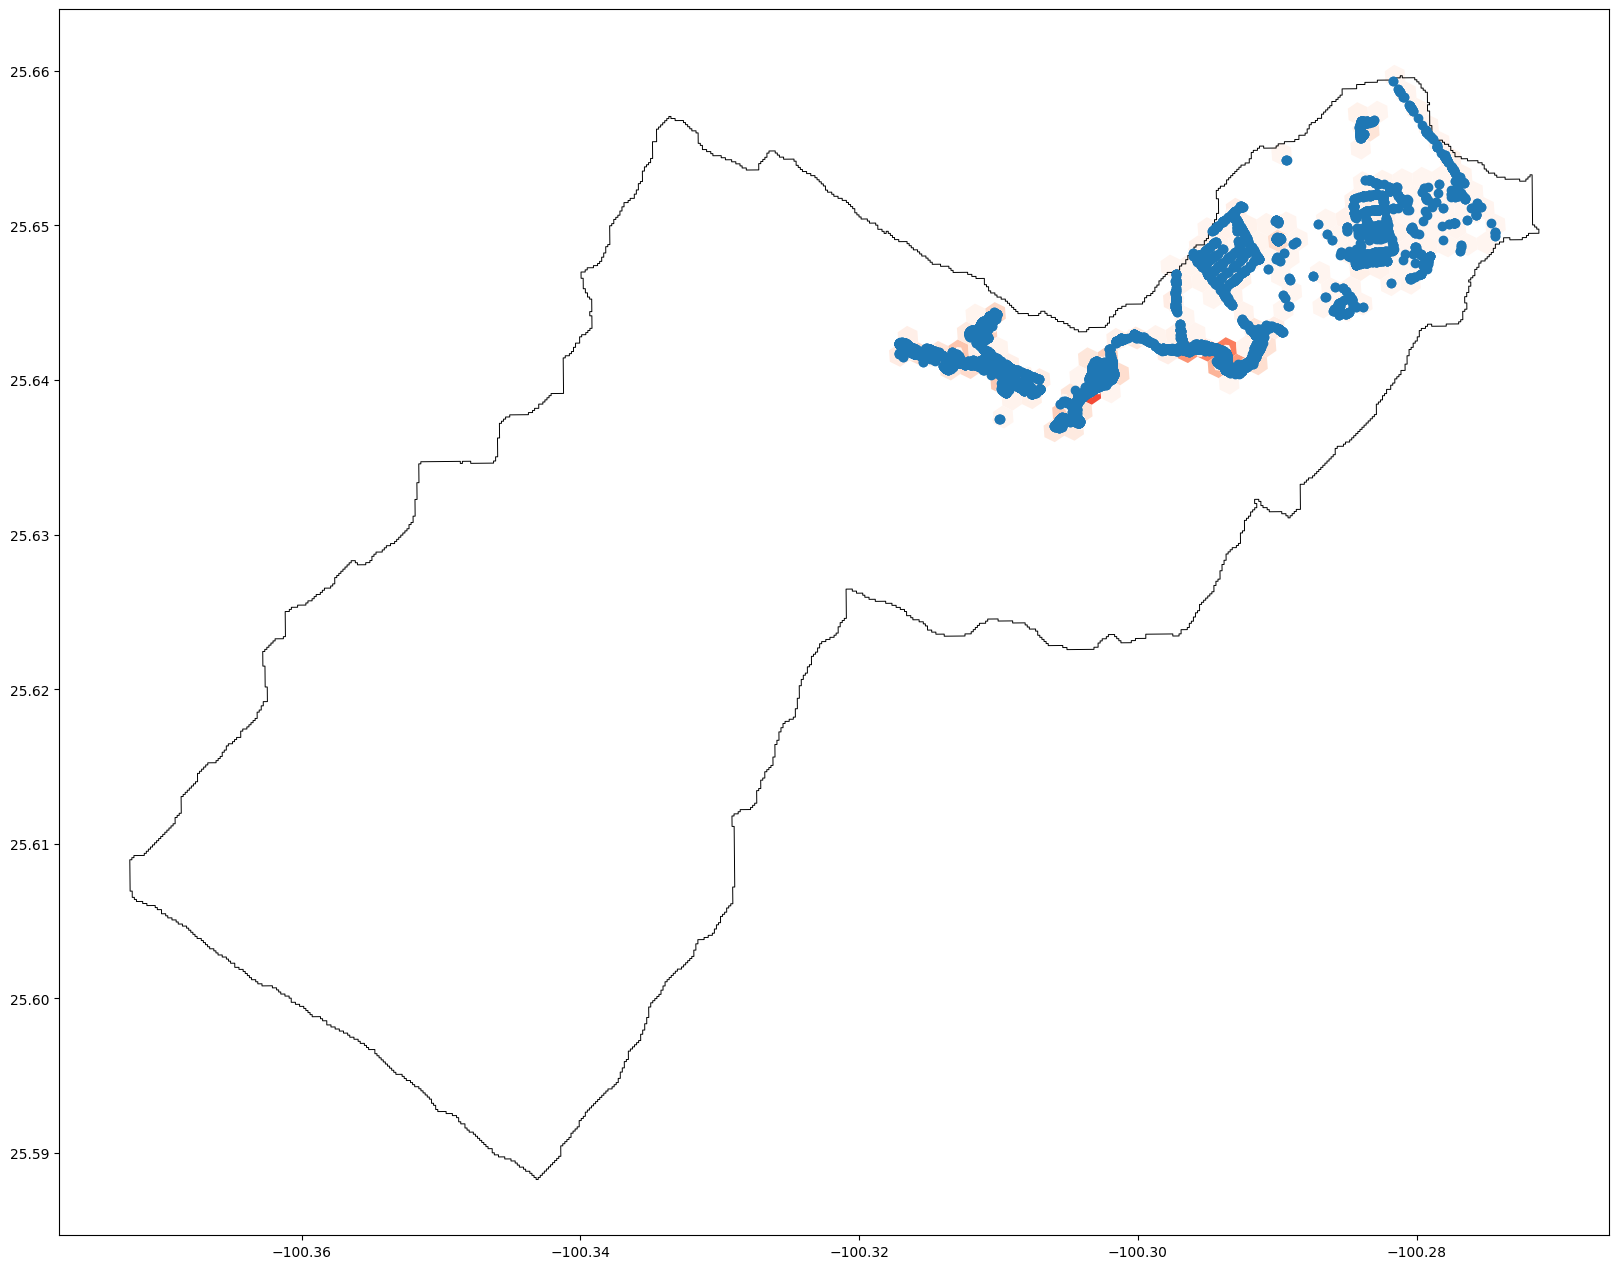

In [9]:
fig,ax = plt.subplots(figsize=(20,20))

summary_f.plot('total_points', cmap='Reds',ax=ax,zorder=0)
aoi.plot(ax=ax, zorder=1, facecolor="none", edgecolor='black', lw=0.7)
pois.plot(ax=ax, zorder=2)

In [10]:
summary_f = summary_f [['hex_id', 'res', 'geometry', 'Aluminio', 'Aluminio_quantity', 'Baterias',
       'Baterias_quantity', 'Carton', 'Carton_quantity', 'Cenizas',
       'Cenizas_quantity', 'Ceramica', 'Ceramica_quantity', 'Electronica',
       'Electronica_quantity', 'Escombros', 'Escombros_quantity', 'Goma',
       'Goma_quantity', 'Llantas', 'Llantas_quantity', 'Madera',
       'Madera_quantity', 'Metal', 'Metal_quantity', 'Organico',
       'Organico_quantity', 'Otros', 'Otros_quantity', 'Papel',
       'Papel_quantity', 'Pesca', 'Pesca_quantity', 'Plastico',
       'Plastico_quantity', 'Salud e higiene', 'Salud e higiene_quantity',
       'Tabaco', 'Tabaco_quantity', 'Tela', 'Tela_quantity', 'Unicel',
       'Unicel_quantity', 'Vidrio', 'Vidrio_quantity', 'EPI', 'EPI_quantity',
       'total_points', 'most_common_point', 'total_quantity',
       'most_common_quantity']]

summary_f.head(2)

,hex_id,res,geometry,Aluminio,Aluminio_quantity,Baterias,Baterias_quantity,Carton,Carton_quantity,Cenizas,...,Unicel,Unicel_quantity,Vidrio,Vidrio_quantity,EPI,EPI_quantity,total_points,most_common_point,total_quantity,most_common_quantity
1111,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity
829,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",10.0,33.0,0.0,0.0,13.0,15.0,2.0,...,57.0,238.0,26.0,55.0,0.0,0.0,1122.0,Plastico,2473.0,Plastico_quantity


In [13]:
columns = summary_f.columns

In [14]:
for column in columns:
    summary_f.rename(columns={column:column.lower()},inplace=True)

summary_f.head(1)  

,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
1111,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity


## Save output

In [15]:
summary_f.to_file(f'../../data/external/temporal_fromjupyter/arroyo_vivo/residuosarroyo_hex.gpkg')

In [16]:
aup.gdf_to_db_slow(summary_f, 'arroyovivo_residuos_hex','projects_research', if_exists='replace')

In [17]:
pois

,itemname,tipo,material,quantity,latitude,longitude,altitude,data_origin,geometry
0,Latas de aluminio o estaño,NaN,Aluminio,11,25.644154,-100.310618,627.104902,9 de enero.csv,MULTIPOINT (-100.31062 25.64415)
1,Latas de aluminio o estaño,NaN,Aluminio,20,25.640925,-100.309352,583.488804,9 de enero.csv,MULTIPOINT (-100.30935 25.64093)
2,Latas de aluminio o estaño,NaN,Aluminio,1,25.656683,-100.283225,526.301173,9 de enero.csv,MULTIPOINT (-100.28322 25.65668)
3,Latas de aluminio o estaño,NaN,Aluminio,1,25.656664,-100.283432,526.532977,9 de enero.csv,MULTIPOINT (-100.28343 25.65666)
4,Latas de aluminio o estaño,NaN,Aluminio,3,25.642555,-100.296862,555.531514,9 de enero.csv,MULTIPOINT (-100.29686 25.64256)
...,...,...,...,...,...,...,...,...,...
16174,Recibos,Papel,Papel,4,25.648461,-100.281661,534.692552,mdt-agosto_2023.csv,MULTIPOINT (-100.28166 25.64846)
16175,Papel,Papel,Papel,3,25.649121,-100.282755,532.680267,mdt-agosto_2023.csv,MULTIPOINT (-100.28276 25.64912)
16176,Papel,Papel,Papel,2,25.648461,-100.281659,534.810559,mdt-agosto_2023.csv,MULTIPOINT (-100.28166 25.64846)
16177,Embalaje de mascarilla facial,EPI,EPI,2,25.649116,-100.282914,533.116858,mdt-agosto_2023.csv,MULTIPOINT (-100.28291 25.64912)


In [18]:
aup.gdf_to_db_slow(pois, 'arroyovivo_residuos_point','projects_research', if_exists='replace')

In [2]:
buffer_dir = f'../../data/external/temporal_todocker/arroyo_vivo/arroyo_buffer200mts_32614.gpkg'
buffer = gpd.read_file(buffer_dir)
buffer = buffer.to_crs("EPSG:4326")

In [3]:
buffer = buffer[['geometry']]
buffer

,geometry
0,"MULTIPOLYGON (((-100.34096 25.62942, -100.3409..."


<Axes: >

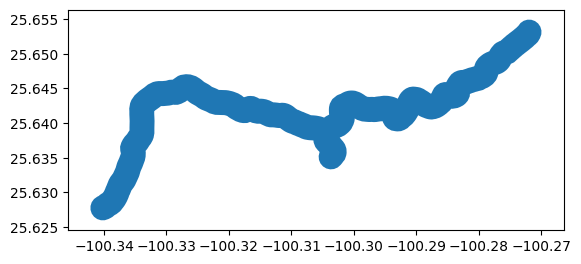

In [4]:
buffer.plot()

In [5]:
aup.gdf_to_db_slow(buffer, 'arroyovivo_buffer200mts','projects_research', if_exists='replace')